In [4]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
from PIL import Image
from pathlib import Path

from core import *

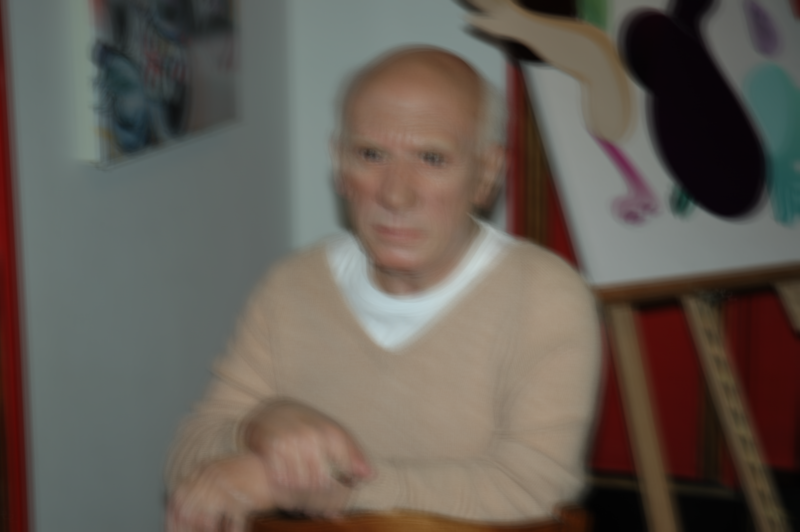

In [ ]:
img_path = Path("../../images/picassoBlurImage.png")
y = to_tensor(Image.open(img_path))
device = "cuda" if torch.cuda.is_available() else "cpu"
y = y.to(device)

Image.open(img_path)

In [8]:
B,C,H,W = y.shape
# Размер ядра (предположим 21x21; если сильное размытие — увеличь)
kernel_size = 21

# Шум для DIP (фиксируем, как в оригинальном DIP)
z = torch.randn(1, 32, H//(2**4), W//(2**4), device=device)

G = DIPDecoder(z_channels=32, out_channels=C, nf=64, num_ups=4).to(device)

# Параметры ядра (логиты), старт — дельта в центре
k_logits = torch.zeros(1,1,kernel_size,kernel_size, device=device)
k_logits[..., kernel_size//2, kernel_size//2] = 10.0  # почти дельта

opt = torch.optim.Adam([
    {"params": G.parameters(), "lr": 1e-3},
    {"params": [k_logits], "lr": 5e-3}
])

lambda_tv = 1e-3      # регуляризация TV на изображение
lambda_k_l2 = 1e-4    # лёгкая L2 на ядро (стягивает «хвосты»)

In [13]:
best_psnr, best = -1, None

def psnr(a,b):
    mse = F.mse_loss(a,b).item()
    if mse==0: return 99.0
    return 10*np.log10(1.0/mse)

for it in range(3000):  # 1–5k шагов обычно хватает
    opt.zero_grad()
    x_hat = G(z)
    x_hat = F.interpolate(x_hat, size=(H, W), mode='bilinear', align_corners=False)
    k = normalize_kernel(k_logits)
    y_hat = conv_img_with_kernel(x_hat, k)

    data_term = F.mse_loss(y_hat, y)
    loss = data_term + lambda_tv*tv_loss(x_hat) + lambda_k_l2*(k**2).mean()
    loss.backward()
    opt.step()

    if it % 100 == 0:
        with torch.no_grad():
            p = psnr(y_hat.clamp(0,1), y)
            # ранняя остановка по кривой валидации у DIP — обычно «на глаз»:
            # можно мониторить рост артефактов и остановиться чуть раньше переобучения
            if p > best_psnr:
                best_psnr = p
                best = (x_hat.detach().clone(), k.detach().clone())
        print(f"[{it}] loss={loss.item():.5f}, psnr={p:.2f} dB")

[0] loss=0.04342, psnr=13.62 dB
[100] loss=0.00315, psnr=25.03 dB
[200] loss=0.00115, psnr=29.40 dB
[300] loss=0.00045, psnr=33.52 dB
[400] loss=0.00018, psnr=37.68 dB
[500] loss=0.00018, psnr=37.51 dB
[600] loss=0.00019, psnr=37.45 dB
[700] loss=0.00009, psnr=40.88 dB
[800] loss=0.00014, psnr=38.70 dB
[900] loss=0.00008, psnr=41.10 dB
[1000] loss=0.00008, psnr=41.36 dB
[1100] loss=0.00007, psnr=42.17 dB
[1200] loss=0.00006, psnr=42.89 dB
[1300] loss=0.00005, psnr=43.20 dB
[1400] loss=0.00005, psnr=43.33 dB
[1500] loss=0.00005, psnr=43.61 dB
[1600] loss=0.00005, psnr=43.82 dB
[1700] loss=0.00005, psnr=43.92 dB
[1800] loss=0.00008, psnr=41.34 dB
[1900] loss=0.00008, psnr=41.44 dB
[2000] loss=0.00004, psnr=44.39 dB
[2100] loss=0.00006, psnr=42.93 dB
[2200] loss=0.00004, psnr=44.89 dB
[2300] loss=0.00014, psnr=38.62 dB
[2400] loss=0.00004, psnr=44.71 dB
[2500] loss=0.00004, psnr=44.88 dB
[2600] loss=0.00005, psnr=43.96 dB
[2700] loss=0.00004, psnr=44.81 dB
[2800] loss=0.00004, psnr=45.41 

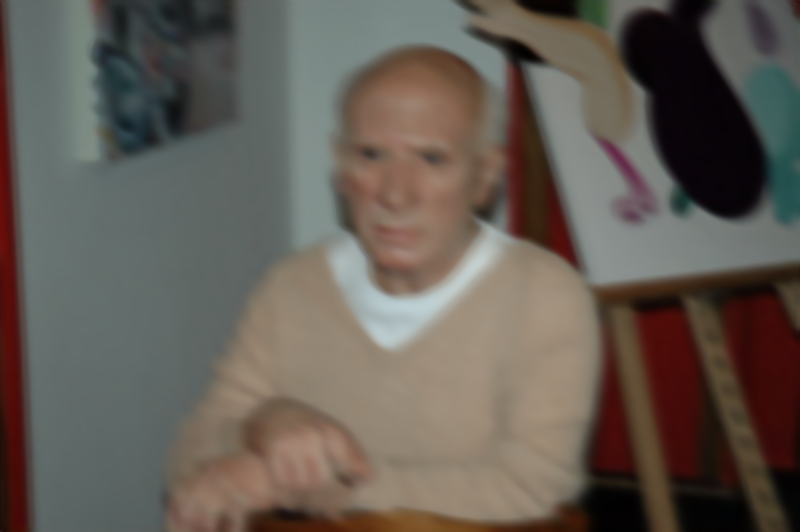

In [15]:
x_rec, k_rec = best

# Красивое ядро для просмотра (нормализуем к [0,1])
k_img = (k_rec - k_rec.min()) / (k_rec.max()-k_rec.min() + 1e-8)
k_np = k_img.squeeze().cpu().numpy()
Image.fromarray((k_np*255).astype(np.uint8)).resize((256,256), Image.NEAREST)

to_pil(x_rec)